<font size="5"><center> <b>Sandpyper: sandy beaches SfM-UAV analysis tools</b></center></font>
<font size="4"><center> <b> Example 6 - Volumetrics </b></center> <br>

    
<center><img src="images/banner.png" width="80%"  /></center>

<font face="Calibri">
<br>
<font size="5"> <b>Volumetrics</b></font>

<br>
<font size="4"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>

<font size="3">Once we have our dataframe holding all the elevation difference points (filtered or not), we can calculate location or transect scales altimetric and volumetric changes. In addition to the raw data, some plotting functions are here introduced. <br>

<b>This notebook covers the following concepts:</b>

- Single location mean elevation change timeseries.
- Altimetric heatmaps and alongshore estimated volume changes.
</font>


</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import datetime

import matplotlib.pyplot as plt
from matplotlib import dates
from sandpyper.volumetrics import (get_state_vol_table, get_transects_vol_table,
                                   plot_alongshore_change, plot_mec_evolution, plot_single_loc)

pd.options.mode.chained_assignment = None  # default='warn'

C:\conda3\envs\sandpyper_env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Prepare the data

In [2]:
# Load dh dataset
dh_path=r"C:\my_packages\doc_data\multitemporal\dh_data.csv"

sand_pts=pd.read_csv(dh_path)

sand_pts.head()

,geometry,location,tr_id,distance,dt,date_pre,date_post,z_pre,z_post,dh
0,POINT (299901.7782793006 5773692.070767866),leo,69,26.8,dt_5,2019-03-28,2019-07-31,0.223866,0.112838,-0.111029
1,POINT (299901.4828779417 5773692.018441608),leo,69,27.1,dt_5,2019-03-28,2019-07-31,0.256890,0.152005,-0.104885
2,POINT (299901.2859437025 5773691.983557437),leo,69,27.3,dt_5,2019-03-28,2019-07-31,0.283333,0.176710,-0.106624
3,POINT (299901.1874765829 5773691.966115351),leo,69,27.4,dt_5,2019-03-28,2019-07-31,0.305573,0.188821,-0.116752
4,POINT (299901.0890094633 5773691.948673265),leo,69,27.5,dt_5,2019-03-28,2019-07-31,0.329158,0.197999,-0.131160


In [3]:
# load the dataframe containing the information of the pre-post surveys

dt_info_path=r"C:\my_packages\doc_data\timesteps_info\dt_info.csv"
dt_info=pd.read_csv(dt_info_path)
dt_info

,dt,date_pre,date_post,location,n_days,loc_full
0,dt_0,2018-06-01,2018-06-21,mar,20,Marengo
1,dt_1,2018-06-21,2018-07-27,mar,36,Marengo
2,dt_2,2018-07-27,2018-09-25,mar,60,Marengo
3,dt_3,2018-09-25,2018-11-13,mar,49,Marengo
4,dt_4,2018-11-13,2018-12-11,mar,28,Marengo
5,dt_5,2018-12-11,2019-02-05,mar,56,Marengo
6,dt_6,2019-02-05,2019-03-13,mar,36,Marengo
7,dt_7,2019-03-13,2019-05-16,mar,64,Marengo
8,dt_0,2018-06-06,2018-07-13,leo,37,St. Leonards
9,dt_1,2018-07-13,2018-07-25,leo,12,St. Leonards


In [4]:
# transform the date_from and date_to fields into useful datetime format.

dates_format_raw= '%Y-%m-%d' # the format the dates are before being transformed (normally '%Y-%m-%d' or '%Y%m%d')

sand_pts["date_pre"]=[datetime.datetime.strptime(str(pre),'%Y-%m-%d') for pre in sand_pts.date_pre]
sand_pts["date_post"]=[datetime.datetime.strptime(str(post),'%Y-%m-%d') for post in sand_pts.date_post]

sand_pts.head()

,geometry,location,tr_id,distance,dt,date_pre,date_post,z_pre,z_post,dh
0,POINT (299901.7782793006 5773692.070767866),leo,69,26.8,dt_5,2019-03-28,2019-07-31,0.223866,0.112838,-0.111029
1,POINT (299901.4828779417 5773692.018441608),leo,69,27.1,dt_5,2019-03-28,2019-07-31,0.256890,0.152005,-0.104885
2,POINT (299901.2859437025 5773691.983557437),leo,69,27.3,dt_5,2019-03-28,2019-07-31,0.283333,0.176710,-0.106624
3,POINT (299901.1874765829 5773691.966115351),leo,69,27.4,dt_5,2019-03-28,2019-07-31,0.305573,0.188821,-0.116752
4,POINT (299901.0890094633 5773691.948673265),leo,69,27.5,dt_5,2019-03-28,2019-07-31,0.329158,0.197999,-0.131160


In [5]:
# Obtain maximum landward limit distances for each location as originally, distances are from sea to land.

land_limits=pd.DataFrame(sand_pts.groupby(["location"]).distance.max()).reset_index()
land_limits

,location,distance
0,leo,43.3
1,mar,64.4


## Beachface change data at transect and location level

The __Mean Elevation Change (MEC)__ is calculated with the totality of the valid points (sand-only, beyond LoD, within the beachface) that occurr both in the pre and post dataset in each location.<br>

The __volumes of beachface change__, instead, are estimated, using the following procedure.

* Along each transect, the non-sand ponts are eliminated and replaced by a linearly interpolated value.
* We integrate the change along the cleaned transect to estimated volumetric change at each transect.
* We multiply the sum of all transect volume change by the transect spacing, to obtain a location-level beachface change estimation.

This approximation is necessary to go from transect change to beachface change.


In [6]:
%%time

# without LoD
location_level_volumetrics=get_state_vol_table(sand_pts=sand_pts,lod=False,
                                              full_specs_table=False)


transect_level_volumetrics=get_transects_vol_table(sand_pts=sand_pts,lod=False,             
                                              full_specs_table=False)

C:\conda3\envs\sandpyper_env\lib\site-packages\sandpyper\volumetrics.py:420: RuntimeWarning: invalid value encountered in true_divide
  tr_df["m3_m"] = (
C:\conda3\envs\sandpyper_env\lib\site-packages\sandpyper\volumetrics.py:431: RuntimeWarning: divide by zero encountered in true_divide
  tr_df["mec_m"] = tr_df.abs_net_change.values / beach_lengths.values


Wall time: 1.04 s


In [7]:
location_level_volumetrics.head()

,location,dt,abs_in,abs_out,abs_net_change,mec_m,norm_in,norm_out,norm_net_change,tot_vol_depo,tot_vol_ero,net_vol_change,location_m3_m,n_obs_valid
0,mar,dt_0,571.411953,-236.998922,334.413031,0.760030,0.139949,-0.058045,0.081904,1891.354036,-876.984423,1014.369613,2.305385,4083
1,mar,dt_1,289.414323,-585.262697,-295.848373,-0.704401,0.066731,-0.134946,-0.068215,627.346716,-1489.400231,-862.053514,-2.052508,4337
2,mar,dt_2,1509.469353,-492.366831,1017.102522,2.421673,0.337840,-0.110198,0.227642,3143.283970,-1154.733373,1988.550597,4.734644,4468
3,mar,dt_3,1113.675874,-1007.085672,106.590202,0.242250,0.245033,-0.221581,0.023452,2540.424755,-2076.349128,464.075627,1.054717,4545
4,mar,dt_4,614.211983,-318.068017,296.143966,0.673054,0.127562,-0.066058,0.061504,1250.355468,-675.751577,574.603891,1.305918,4815


In [8]:
transect_level_volumetrics.head()

,tr_id,tot_vol_change,m3_m,n_obs_valid,abs_in,abs_out,abs_net_change,mec_m,norm_in,norm_out,norm_net_change,dt,location
0,3,7.818762,-6.626069,156,39.440407,0.000000,39.440407,-1.671204,0.252823,0.000000,0.252823,dt_0,mar
1,4,2.283335,-1.729799,221,26.626025,-3.101110,23.524915,-0.891095,0.120480,-0.014032,0.106448,dt_0,mar
2,5,3.494555,-2.730121,227,37.810089,-1.907328,35.902761,-1.402452,0.166564,-0.008402,0.158162,dt_0,mar
3,6,1.851830,-1.346785,252,42.332045,-21.844393,20.487652,-0.745006,0.167984,-0.086684,0.081300,dt_0,mar
4,7,3.514147,-3.082585,217,33.533976,-0.932927,32.601049,-1.429871,0.154534,-0.004299,0.150235,dt_0,mar


In [9]:
# Let's add the pre-post info

location_level_volumetrics=pd.merge(location_level_volumetrics,
                                         dt_info,
                                         on=['location','dt'])

location_level_volumetrics.head()

,location,dt,abs_in,abs_out,abs_net_change,mec_m,norm_in,norm_out,norm_net_change,tot_vol_depo,tot_vol_ero,net_vol_change,location_m3_m,n_obs_valid,date_pre,date_post,n_days,loc_full
0,mar,dt_0,571.411953,-236.998922,334.413031,0.760030,0.139949,-0.058045,0.081904,1891.354036,-876.984423,1014.369613,2.305385,4083,2018-06-01,2018-06-21,20,Marengo
1,mar,dt_1,289.414323,-585.262697,-295.848373,-0.704401,0.066731,-0.134946,-0.068215,627.346716,-1489.400231,-862.053514,-2.052508,4337,2018-06-21,2018-07-27,36,Marengo
2,mar,dt_2,1509.469353,-492.366831,1017.102522,2.421673,0.337840,-0.110198,0.227642,3143.283970,-1154.733373,1988.550597,4.734644,4468,2018-07-27,2018-09-25,60,Marengo
3,mar,dt_3,1113.675874,-1007.085672,106.590202,0.242250,0.245033,-0.221581,0.023452,2540.424755,-2076.349128,464.075627,1.054717,4545,2018-09-25,2018-11-13,49,Marengo
4,mar,dt_4,614.211983,-318.068017,296.143966,0.673054,0.127562,-0.066058,0.061504,1250.355468,-675.751577,574.603891,1.305918,4815,2018-11-13,2018-12-11,28,Marengo


## Plot single location Mean Elevation Change timeseries

In [10]:
df=location_level_volumetrics # this must be the location level dataframe
figsize=(8.5,4)
loc_subset=["mar"] # the function is optimised for single-location plots, but you can also pass a list of location codes
colors_dict={"mar":'r',        # if you use multiple locations, then dictionary key is the location code and value the color
            "leo":'b'}
linewidth=1.5                  # lines widths
out_date_format="%d/%m/%Y"     # format of the x-axis, which holds the survey dates
xlabel="Survey date" 
ylabel="Volume change (m³)"
suptitle="Volumetric Timeseries"

Color dictionary provided.


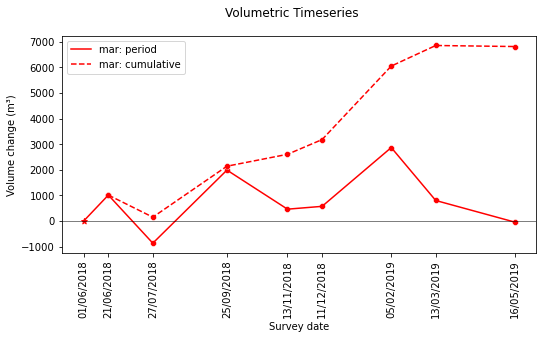

In [11]:
ax=plot_single_loc(df=df,
                loc_subset=loc_subset,
                figsize=figsize,
                colors_dict=colors_dict,
                linewidth=linewidth,
                out_date_format=out_date_format,
                xlabel=xlabel,
                ylabel=ylabel,
                suptitle=suptitle)


In [12]:
# Uncomment the below line if the image needs to be saved and replace the path.

# f.savefig(r'E:\mary\apo\apo_vol_timeseries.png', dpi=300, bbox_inches='tight')

##  Altimetric heatmaps and alongshore estimated volume changes
Here, we can display the alongshore estimated eroded/deposited volumes acrosse the surveyed beach.

__Note:__ The net volume change is estimated by sweeping the transect-specific value to the next transect.


In [13]:
# Set plot fonts style

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'

In [14]:
# Set plot fonts style
loc_in='mar' # the code of the location to be plotted

# quick way to create a list of periods from the location
dts=list(location_level_volumetrics.query(f"location=='{loc_in}'").dt.unique())

# or, manually enter the periods you want to plot
# dts=['dt_1'] 


Here below, let's set the parameters for the plots!

In [15]:
sand_pts=sand_pts # the dh table

lod=0.05 # can be the LoD table path, a numeric value or False, which will not use LoDs filter.

return_data= True # wether or not (True or False) create a dataframe with summary info

full_specs_table=dt_info # provide the details table path or set to False to not use it

mode="subset" # if 'subset', only the provided location_subset and dt_subset will be plotted. If 'all', plot all.

location_subset=['mar'] # provide a list of location codes. Only these locations will be plotted

dt_subset=dts # provide a list of dt codes. Only these time period will be plotted

y_heat_bottom_limit=40 # bottom limit of the heatmaps (altimetric change)

ax2_y_lims=[-20,20] # axis limit of the alongshore volumetric plot

save=False # True to save each plot

save_path=None # specify the folder where the plots need to be saved, if save = True

Working on mar at dt_0


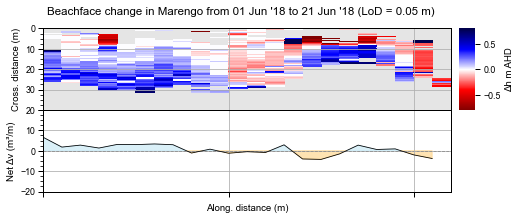

Working on mar at dt_1


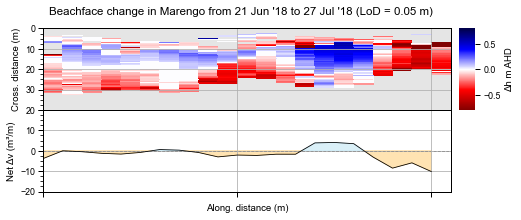

Working on mar at dt_2


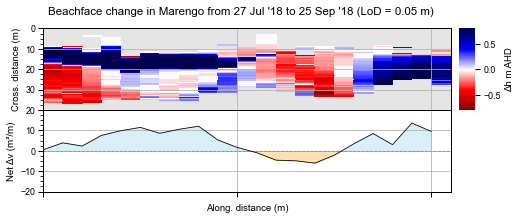

Working on mar at dt_3


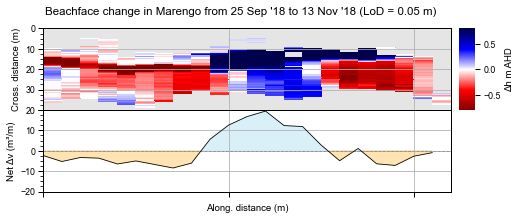

Working on mar at dt_4


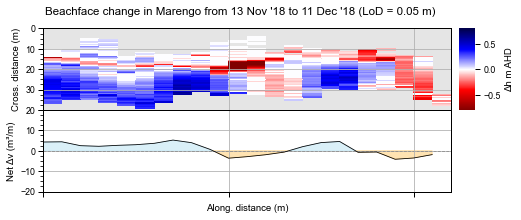

Working on mar at dt_5


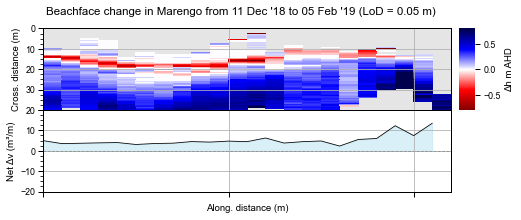

Working on mar at dt_6


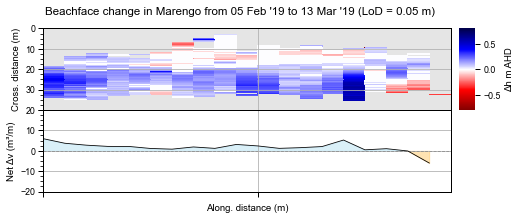

Working on mar at dt_7


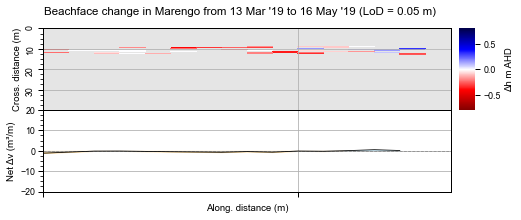

In [16]:
# RUN THE FUNCTION

data=plot_alongshore_change(sand_pts=sand_pts,
                           lod=lod,
                           return_data=return_data,
                           full_specs_table=full_specs_table,
                           mode=mode,
                           location_subset=location_subset,
                           dt_subset=dt_subset,
                           y_heat_bottom_limit=y_heat_bottom_limit,
                           ax2_y_lims=ax2_y_lims,
                           save=save,
                           save_path=save_path)

##  Multilocation MEC timeseries

In [17]:
# sort the location codes. These will appear from right to left in the x-axis of the plot

volumetrics=location_level_volumetrics

loc_order=["mar","leo"]

sorterIndex = dict(zip(loc_order,range(len(loc_order))))
volumetrics['loc_rank']=volumetrics['location'].map(sorterIndex)
volumetrics.sort_values(["loc_rank"], inplace=True)

# [OPTIONAL] replace long location names with shorter versions
volumetrics.replace("St. Leonards","St. Leo.", inplace=True)

# volumetrics=pd.merge(volumetrics,locs_dt_str[["loc_code","loc_full"]], left_on='location',right_on='loc_code', how='left')

volumetrics.query("location=='mar'")

,location,dt,abs_in,abs_out,abs_net_change,mec_m,norm_in,norm_out,norm_net_change,tot_vol_depo,tot_vol_ero,net_vol_change,location_m3_m,n_obs_valid,date_pre,date_post,n_days,loc_full,loc_rank
0,mar,dt_0,571.411953,-236.998922,334.413031,0.760030,0.139949,-0.058045,0.081904,1891.354036,-876.984423,1014.369613,2.305385,4083,2018-06-01,2018-06-21,20,Marengo,0
1,mar,dt_1,289.414323,-585.262697,-295.848373,-0.704401,0.066731,-0.134946,-0.068215,627.346716,-1489.400231,-862.053514,-2.052508,4337,2018-06-21,2018-07-27,36,Marengo,0
2,mar,dt_2,1509.469353,-492.366831,1017.102522,2.421673,0.337840,-0.110198,0.227642,3143.283970,-1154.733373,1988.550597,4.734644,4468,2018-07-27,2018-09-25,60,Marengo,0
3,mar,dt_3,1113.675874,-1007.085672,106.590202,0.242250,0.245033,-0.221581,0.023452,2540.424755,-2076.349128,464.075627,1.054717,4545,2018-09-25,2018-11-13,49,Marengo,0
4,mar,dt_4,614.211983,-318.068017,296.143966,0.673054,0.127562,-0.066058,0.061504,1250.355468,-675.751577,574.603891,1.305918,4815,2018-11-13,2018-12-11,28,Marengo,0
5,mar,dt_5,1612.177720,-168.924969,1443.252751,3.280120,0.266784,-0.027954,0.238831,3348.259553,-480.364849,2867.894704,6.517943,6043,2018-12-11,2019-02-05,56,Marengo,0
6,mar,dt_6,455.317056,-51.387106,403.929950,1.062974,0.119193,-0.013452,0.105741,964.003793,-161.317141,802.686653,2.112333,3820,2019-02-05,2019-03-13,36,Marengo,0
7,mar,dt_7,2.003538,-5.583613,-3.580075,-0.011188,0.044523,-0.124080,-0.079557,6.592363,-47.381364,-40.789002,-0.127466,45,2019-03-13,2019-05-16,64,Marengo,0


KeyError: 'date_post_dt'

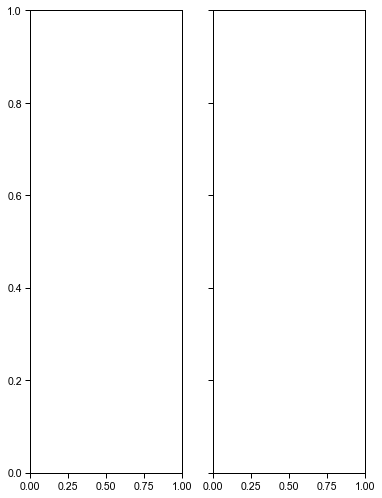

In [18]:
x_diff={"mar":[-1,1]}

plot_mec_evolution(volumetrics,
                   loc_order=["mar","leo"],
                   scale_mode='equal',
                   x_diff=x_diff,
                   x_limits=[-0.3,0.3],
                   font_scale=1.2,
                   location_field='location',
                   figure_size=(6,8.5))

___